# Purpose of this notebook



**"I have a million documents, what do I do?"**

One thing might be to index the text, to be able to search it more easily, and on your own terms.


ElasticSearch is an established search engine; you can throw millions of documents at it
and still get fast results.

It's also not _that_ scary beyond the verbosity of its documentation.
It takes some getting used to, though.


**Install**

In theory this is like any other service, and your package manager / docker image / such
may take care of basic configuration.

You may want to check that you're on a Basic license.
(if you're on a Trial license you may have a setup that will stop working once tha trial ends).

While optional (and more setup), you may also like to install kibana,
because there are two tools in in (Stack Monitoring, and Dev Tools -> Console) that are great feedback
while you're indexing and searching.


**Indexing**

Mostly two steps:
- tell it how exactly to interpret the items you will send it (in JSON form) - it'll work without this, but it's less controlled e.g. around identifiers
- send it those

There notebook is primarily made of "wetsuite dataset in, data towards ES out" examples.


**Searching**

ES has its own query language, which is flexible but... made for programmers. 
You often will have something to take a nice form and transform that into a useful query.

At the bottom of this notebook is a 'proof of search doing a thing' example.


In theory you can have a static HTML page send queries straight to the elasticsearch HTTP API,
and turn the resulting data into a nice HTML page with scripting.

In practice you often place something inbetween to do extra work for you,
e.g. controlling what kind of searches get posted, possibly formatting and augmenting the results.

In [1]:
import pprint,  urllib3

import wetsuite.datasets
import wetsuite.helpers.notebook
import wetsuite.helpers.koop_parse

import elasticsearch, elasticsearch_dsl

# suppress "you are connecting to ES without certificate verification" warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [ ]:
es = elasticsearch.Elasticsearch( hosts=["https://localhost:9200/"], 
                                  verify_certs=False, 
                                  http_auth=('elastic','hackme') ) # basic_auth in 8+    TODO: make/use search user

/usr/local/lib/python3.8/dist-packages/elasticsearch/connection/http_urllib3.py:209: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(


## Index

There are some practical details that the below is not really discussing, such as
- if you have identical field names in otherwise different indices, you can make it easier to 
  - search in all at the same time  (e.g. `plaintext` and/or `title` in the query just works in all)
  - make your eventual presentation code easier  (e.g. `web_url`, `xml_url`)
  - you might consider duplicating specific identifiers into an `indentifier` - but only if you really care to have an 'exact identifier lookup among different types of documents'

### BWB

In [ ]:
# Decide on what the index should store and how to interpret/index it  (in ES terms: set the mapping)
#es.indices.delete(index='bwb') # , ignore=[400, 404]   # when you want to clear the entire index, e.g. to start with a significantly different mapping
if not es.indices.exists(index='bwb'):
    print("Index bwb doesnt exist, setting mapping")
    mappings={
        'mappings':{  
            'properties':{  
                'identifier':{   'type':'keyword' },
                'bwbr':{         'type':'text'    },

                'soort':{        'type':'keyword' },

                'intitule':{     'type':'text', "analyzer": "dutch" },
                'citeertitel':{  'type':'text', "analyzer": "dutch" },
                'plaintext':{    'type':'text', "analyzer": "dutch" },

                'xml':{          'type':'text', 'store':True, 'index':False },
                
                'web_url':{      'type':'text', 'store':True, 'index':False },
                'xml_url':{      'type':'text', 'store':True, 'index':False },
                #'toestand_url':{ 'type':'text', 'store':True, 'index':False },
                'manifest_url':{ 'type':'text', 'store':True, 'index':False },
                'wti_url':{      'type':'text', 'store':True, 'index':False },
                #'meta':{ 'type':'object' },
            }
        }, 
        'settings':{'refresh_interval':'30s', 'index.translog.durability':'async'} 
    }
    es.indices.create(index='bwb', body=mappings)

In [98]:
# Load datasets we'll be inserting from
bwb_xml  = wetsuite.datasets.load('bwb-mostrecent-xml')
bwb_text = wetsuite.datasets.load('bwb-mostrecent-text')
bwb_meta = wetsuite.datasets.load('bwb-mostrecent-meta-struc')
# show one item, to give some context to what we're picking out (and what we might like to refine later)
bwb_meta.data.random_choice()[1]

{'bwb-id': 'BWBR0010916',
 'intitule': 'Besluit van 1 december 1999, houdende het van toepassing zijn van het reglement betreffende het verlenen van radarpatenten (Besluit Reglement radarpatenten)',
 'citeertitel': 'Besluit Reglement radarpatenten',
 'soort': 'AMvB',
 'inwerkingtredingsdatum': '2000-01-01',
 'latest_toestand_url': 'https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0010916/2000-01-01_0/xml/BWBR0010916_2000-01-01_0.xml',
 'wti_url': 'https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0010916/BWBR0010916.WTI',
 'wti': {'algemene_informatie': {'citeertitels_withdate': [['2000-01-01',
     '9999-12-31',
     'Besluit Reglement radarpatenten']],
   'citeertitels_distinct': ['Besluit Reglement radarpatenten'],
   'eerstverantwoordelijke': 'Infrastructuur en Milieu',
   'identificatienummer': 'BWBR0010916',
   'rechtsgebieden': [['Vervoersrecht', None]],
   'overheidsdomeinen': ['Verkeer en vervoer']},
  'related': [['grondslagen',
    'BWBR0004364',
    '

In [ ]:
# Pick out the data for each item, create the document structure we just promised ES we'd give it

actions = []
for url, item in wetsuite.helpers.notebook.ProgressBar( bwb_meta.data.items() ):
    doc = {}  # 'collection':'bwb'
    doc['identifier']    = item.get('bwb-id')
    doc['bwbr']          = item.get('bwb-id')

    doc['soort']         = item.get('soort')

    doc['intitule']      = item.get('intitule')
    doc['citeertitel']   = item.get('citeertitel')
    doc['plaintext']     = bwb_text.data.get( url )

    #doc['xml']          = bwb_xml.data.get( item.get('bwb-id') )       # not sure this is worth the size, until someone needs it

    doc['web_url']       = 'https://wetten.overheid.nl/%s'%doc['bwbr']
    doc['xml_url']       = item.get('latest_toestand_url')
    doc['manifest_url']  = item.get('latest_toestand_url')
    doc['wti_url']       = item.get('wti_url')

    doc['version_dates'] = []
    for wijziging in item.get('wti').get('wijzigingen'):
        if wijziging.get('betreft') in ('nieuwe-regeling','wijziging'): 
            nww = wijziging.get('waarde')
            if nww is not None:
                doc['version_dates'].append( nww )
            #else:    print(wijziging)
        # other betreft values include 'intrekking-regeling', 'Aanhangig', 'tekstplaatsing', 'herplaatsing'

    doc['authority']         = item.get('wti').get('algemene_informatie').get('eerstverantwoordelijke')
    rg = [] # flatten for now. The source data is pairs that are like a 2-deep tree, which may have no leaf,  [['Openbare orde en veiligheidsrecht', None]],
    for g,s in item.get('wti').get('algemene_informatie').get('rechtsgebieden'):
        rg.append(g)
        if not s is None:
            rg.append(s)
    doc['rechtsgebieden']    = rg
    doc['overheidsdomeinen'] = item.get('wti').get('algemene_informatie').get('overheidsdomeinen')

    #pprint.pprint(doc) # if you want to see the thing we just made

    actions.append( {"update": {"_index": 'bwb', "_id":doc['identifier'] }} )
    actions.append( {'doc': doc, 'doc_as_upsert':True, 'detect_noop':True} )
    # strictly updating one doc at a time is slow, tens to hundreds at a time (using the bulk interface) is _much_ faster,
    # so we collect these until we have a bunch and then send in the set
    # (note: diminishing returns and there is a request size limit and timeout, so more than a few hundred is unnecessary)
    if len(actions) > 300: # (without the XML, this is around a MByte.   TODO: use that debug line's output to do it based on _size_ instead)
        #print('Bulk request size ~= %sB'%wetsuite.helpers.format.kmgtp(len(json.dumps(actions)), kilo=1024))
        es.bulk(index='bwb', body=actions, request_timeout=120)
        actions=[]

# add the last bunch
if len(actions)>0:
    es.bulk(index='bwb', body=actions, request_timeout=120)

es.indices.refresh(index="bwb")

### CVDR

In [107]:
#es.indices.delete(index='cvdr') # , ignore=[400, 404]   # only uncomment for mapping changes
if not es.indices.exists(index='cvdr'):
    print("Index cvdr doesnt exist, setting mapping")
    mappings={
        'mappings':{  
            'properties':{  
                'identifier':{ 'type':'keyword' },
                'work_id':{ 'type':'keyword' },
                'expression_id':{ 'type':'keyword' },
                'title':{ 'type':'text', "analyzer": "dutch" },
                'alternative':{ 'type':'text' },
                'plaintext':{ 'type':'text', "analyzer": "dutch" },
                'web_url':{ 'type':'text', 'store':True, 'index':False },
                'xml_url':{ 'type':'text', 'store':True, 'index':False },

                # REMEMBER why these weren't in there
                'subject':{ 'type':'text' },
                'creator':{ 'type':'text' },
                'spatial':{ 'type':'text' },
            }
        }, 
        'settings':{'refresh_interval':'30s', 'index.translog.durability':'async'} 
    }
    es.indices.create(index='cvdr', body=mappings)

In [3]:
# Load datasets we'll be inserting from
cvdr_xml  = wetsuite.datasets.load('cvdr-mostrecent-xml')
cvdr_text = wetsuite.datasets.load('cvdr-mostrecent-text')
cvdr_meta = wetsuite.datasets.load('cvdr-mostrecent-meta-struc')
# show one item, to give some context to what we're picking out (and what we might like to refine later)
cvdr_meta.data.random_choice()[1]

{'identifier': 'CVDR314816_1',
 'title': 'Verordening op de heffing en de invordering van lijkbezorgingsrechten 2014',
 'language': 'nl',
 'type': 'regeling (overheid:Informatietype)',
 'creator': 'Asten (overheid:Gemeente)',
 'modified': '2017-10-03',
 'spatial': 'Asten (overheid:Gemeente)',
 'isFormatOf': 'Peelbelang 19-12-2013 ()',
 'alternative': 'Verordening lijkbezorgingsrechten 2014',
 'source': 'artikel 229, eerste lid, aanhef en onderdelen a en b, van de Gemeentewet (1.0:v:BWBR0005416&artikel=229)',
 'isRatifiedBy': 'gemeenteraad (overheid:BestuursorgaanGemeente)',
 'subject': 'bestuur en recht',
 'issued': '2013-12-17',
 'rights': 'De tekst in dit document is vrij van auteursrecht en\n                    databankrecht',
 'inwerkingtredingDatum': '2014-01-01',
 'uitwerkingtredingDatum': '2015-01-01',
 'betreft': 'Nieuwe regeling',
 'kenmerk': '13.12.11',
 'onderwerp': 'financien en economie',
 'redactioneleToevoeging': 'Tarieventabel'}

In [ ]:
#import wetsuite.helpers.etree
#wetsuite.helpers.etree.debug_color( cvdr_xml.data.random_values(1)[0] )

In [ ]:
actions = []
for url, item in wetsuite.helpers.notebook.ProgressBar( cvdr_meta.data.items() ):
    doc = {}  # 'collection':'cvdr'

    doc['identifier']                    = item.get('identifier')
    doc['work_id'], doc['expression_id'] = wetsuite.helpers.koop_parse.cvdr_parse_identifier( item.get('identifier') )
    doc['title']                         = item.get('title')
    doc['alternative']                   = item.get('alternative')
    doc['plaintext']                     = cvdr_text.data.get( url )
    doc['subject']                       = item.get('subject')
    doc['creator']                       = item.get('creator')
    doc['spatial']                       = item.get('spatial')
    #TODO: re-check whether these are the best ways to figure these out - I seem to remember there are exception cases that are best solved by taking this from metadata?
    #doc['web_url']                       = 'https://lokaleregelgeving.overheid.nl/CVDR%s'%doc['expression_id'].replace('_',/')
    doc['web_url']                       = 'https://lokaleregelgeving.overheid.nl/CVDR%s'%doc['work_id']
    work,ver = doc['expression_id'].split('_', 1)
    # TODO: VERIFY the XML URLs - I think this is not always correct, and not actually metioned in document metadata, only in the search metadata, which we do not currently store?
    doc['xml_url']                       = f'https://repository.officiele-overheidspublicaties.nl/cvdr/CVDR{work}/{ver}/xml/CVDR{work}_{ver}.xml' 

    # TODO: finish
    #'inwerkingtreding', 'uitwerkingtreding', 'issued', 

    #pprint.pprint(doc) # if you want to see the thing we just made

    actions.append( {"update": {"_index": 'cvdr', "_id":doc['identifier'] } } )
    actions.append( {'doc':doc,  'doc_as_upsert':True,  'detect_noop':True  } )
    # strictly updating one doc at a time is slow, tens to hundreds at a time (using the bulk interface) is _much_ faster,
    # so we collect these until we have a bunch and then send in the set
    # (note: diminishing returns and there is a request size limit and timeout, so more than a few hundred is unnecessary)
    if len(actions) > 300: # (without the XML, this is around a MByte.   TODO: based on _size_ instead, e.g. use that debug line's output)
        #print('Bulk request size ~= %sB'%wetsuite.helpers.format.kmgtp(len(json.dumps(actions)), kilo=1024))
        es.bulk(index='cvdr', body=actions, request_timeout=120)
        actions=[]

# add the last bunch
if len(actions)>0:
    es.bulk(index='cvdr', body=actions, request_timeout=120)

es.indices.refresh(index="cvdr")

  0%|          | 0/235725 [00:00<?, ?it/s]

{'_shards': {'total': 2, 'successful': 1, 'failed': 0}}

### RECHTSPRAAKNL

In [10]:
#es.indices.delete(index='rechtspraaknl') # , ignore=[400, 404]   # only uncomment for mapping changes

if not es.indices.exists(index='rechtspraaknl'):
    print("Index rechtspraaknl doesnt exist, setting mapping")
    mappings={
        'mappings':{  
            'properties':{
                'identifier':{      #'type':'keyword' }, # actually, its parts are also interesting
                                     'type':'text'    }, 
                'type':            { 'type':'keyword' },
                'plaintext':       { 'type':'text', "analyzer": "dutch" },
                'inhoudsindicatie':{ 'type':'text', "analyzer": "dutch" },
                #'xml':{ 'type':'text', 'store':True, 'index':False },
            }
        },
        'settings':{'refresh_interval':'30s', 'index.translog.durability':'async'} 
    }
    es.indices.create(index='rechtspraaknl', body=mappings)

In [11]:
rechtspraaknl_struc  = wetsuite.datasets.load('rechtspraaknl-struc')
rechtspraaknl_struc.data.random_choice()[1]

{'identifier': 'ECLI:NL:RBGEL:2020:5714',
 'issued': '2020-10-28',
 'publisher': 'Raad voor de Rechtspraak',
 'date': '2020-10-28',
 'type': 'Uitspraak',
 'modified': '2021-05-28T15:12:35',
 'zaaknummer': '05.103225.20',
 'creator': 'Rechtbank Gelderland',
 'subject': 'Strafrecht',
 'spatial': 'Arnhem',
 'inhoudsindicatie': 'Bewezenverklaring van brandstichting in een tussenwoning, met gemeen gevaar voor goederen (o.a. naastgelegen woningen) en levensgevaar voor personen (buren). De man is veroordeeld tot een gevangenisstraf van vier jaren, waarvan één jaar voorwaardelijk met bijzondere voorwaarden, en hij moet ruim € 14.500,- aan schadevergoedingen betalen.',
 'bodytext': '\n\n1\nDe inhoud van de tenlastelegging\n\nAan verdachte is ten laste gelegd dat:\n\n1.\n\nhij op of omstreeks 15 april 2020 in de gemeente Arnhem, opzettelijk \nbrand heeft gesticht in een woning gelegen aan de [adres 1] \n , immers heeft verdachte toen aldaar opzettelijk\n\n- een tapijt/kleed en/of een houten park

In [ ]:
actions = []
for url, item in wetsuite.helpers.notebook.ProgressBar( rechtspraaknl_struc.data.items() ):
    doc = {} # 'collection':'rechtspraaknl'

    doc['identifier']         = item.get('identifier')
    doc['type']               = item.get('type')

    doc['plaintext']          = item.get('bodytext')
    doc['inhoudsindicatie']   = item.get('inhoudsindicatie')

    doc['creator']            = item.get('creator')
    doc['spatial']            = item.get('spatial')
    doc['subject']            = item.get('subject')

    doc['date']               = item.get('date')
    doc['issued']             = item.get('issued')

    doc['web_url']            = 'https://uitspraken.rechtspraak.nl/InzienDocument?id=%s'%doc['identifier']
    doc['xml_url']            = 'https://data.rechtspraak.nl/uitspraken/content?id=%s'%doc['identifier']

    #pprint.pprint(doc) # if you want to see the thing we just made

    actions.append( {"update": {"_index": 'rechtspraaknl', "_id":doc['identifier'] }} )
    actions.append( {'doc': doc, 'doc_as_upsert':True, 'detect_noop':True} )
    # strictly updating one doc at a time is slow, tens to hundreds at a time (using the bulk interface) is _much_ faster,
    # so we collect these until we have a bunch and then send in the set
    # (note: diminishing returns and there is a request size limit and timeout, so more than a few hundred is unnecessary)
    if len(actions) > 300: # (without the XML, this is around a MByte.   TODO: use that debug line's output to do it based on _size_ instead)
        #print('Bulk request size ~= %sB'%wetsuite.helpers.format.kmgtp(len(json.dumps(actions)), kilo=1024))
        es.bulk(index='rechtspraaknl', body=actions, request_timeout=120)
        actions=[]

# add the last bunch
if len(actions)>0:
    es.bulk(index='rechtspraaknl', body=actions, request_timeout=120)

es.indices.refresh(index="rechtspraaknl")

### EUR-Lex

In [133]:
eurlex_dir   = wetsuite.datasets.load('eurlex-dir-nl-struc')
eurlex_judg  = wetsuite.datasets.load('eurlex-judg-nl-struc')
eurlex_reg   = wetsuite.datasets.load('eurlex-reg-nl-struc')
eurlex_reg.data.random_choice()[1]

{'celex': '31982R2299',
 'titles': {'title': 'Verordening (EEG) nr. 2299/82 van de Commissie van 19 augustus 1982 tot wijziging van de invoerheffingen voor op basis van granen en rijst verwerkte produkten',
  'englishTitle': 'Commission Regulation (EEC) No 2299/82 of 19 August 1982 altering the import levies on products processed from cereals and rice',
  'originalTitle': 'Verordening (EEG) nr. 2299/82 van de Commissie van 19 augustus 1982 tot wijziging van de invoerheffingen voor op basis van granen en rijst verwerkte produkten'},
 'dates': {'Date of document': '1982-08-20'},
 'misc': {'Author': 'Europese Commissie', 'Form': 'Verordening'},
 'proc': {},
 'linked': {'Link': ''},
 'doctrine': {},
 'classifications': {},
 'contents': [['DA',
   'PDF',
   'https://eur-lex.europa.eu/legal-content/DA/TXT/PDF/?uri=CELEX:31982R2299'],
  ['DE',
   'PDF',
   'https://eur-lex.europa.eu/legal-content/DE/TXT/PDF/?uri=CELEX:31982R2299'],
  ['EL',
   'PDF',
   'https://eur-lex.europa.eu/legal-conten

In [ ]:
#es.indices.delete(index='eurlex') # , ignore=[400, 404]   # only uncomment for mapping changes
if not es.indices.exists(index='eurlex'):
    print("Index eurlex doesnt exist, setting mapping")
    mappings={
        'mappings':{  
            'properties':{  
                'identifier':{ 'type':'keyword' }, 
                'title':     { 'type':'text', "analyzer": "dutch" },
                'ecli':      { 'type':'keyword' },
                'urls':      { 'type':'keyword', 'store':True, 'index':False },
                'plaintext':{ 'type':'text', "analyzer": "dutch" },
                'web_url':   { 'type':'keyword' },
            }
        },
        'settings':{'refresh_interval':'30s', 'index.translog.durability':'async'} 
    }
    es.indices.create(index='eurlex', body=mappings)

In [ ]:
eurlex_fields = [ # which fields we can copy-paste
    'identifier', 
    'type',
    'creator', 'spatial', 'subject'
    'date', 'issued', 
    'inhoudsindicatie', 'plaintext', 
]

actions = []
for url, item in wetsuite.helpers.notebook.ProgressBar( eurlex_reg.data.items() ):
    doc = {} # 'collection':'rechtspraaknl'

    #doc['identifier']         = item.get('celex')
    #doc['title']              = list(set(v   for  k,v in item.get('titles').items() ))

    doc['web_url']            = url


    for key, val in item.items():
        if key in eurlex_fields:
            doc[key] = val

    def simplkey(s):
        return s.lower().replace(' ','_').replace('-','_')

    # flatten these things - TODO: normalize more, the keys are probably not as strict as we're assuming.

    if 'celex' in item: # there's one or two without the body mentioning it, which seem to be errors
        doc['identifier'] = item['celex']
        del item['celex'] # for "what's left?" debug below

        # store all variant titles in 'titles', and choose a preferred one for 'title'
        doc['titles'] = []
        pref = { 'englishTitle':0, 'originalTitle':2, 'title':1 }
        preftitle = ''
        prefscore = -2
        for titlekey, title in item['titles'].items():
            doc['titles'].append(title)
            score = pref.get(titlekey, -1)
            if score > prefscore:
                preftitle = title
                prefscore = score
        doc['title'] = preftitle
        del item['titles'] # for "what's left?" debug below

        if type(item['proc']) is list:
            print( item['proc'] )
        for k,v in item['proc'].items():
            doc['proc_%s'%simplkey(k)] = v
        del item['proc'] # for "what's left?" debug below

        for k,v in item['misc'].items():
            doc['misc_%s'%simplkey(k)] = v
        del item['misc'] # for "what's left?" debug below

        for k,v in item['doctrine'].items():
            doc['doctrine_%s'%simplkey(k)] = v
        del item['doctrine'] # for "what's left?" debug below

        for k,v in item['dates'].items():
            doc['date_%s'%simplkey(k)] = v
        del item['dates'] # for "what's left?" debug below

        doc['linked_celex'] = []
        for k,vl in item['linked'].items():
            if type(vl) is list: #TODO: properly
                for celex, linktext in vl:
                    #TODO: check celex for validity
                    doc['linked_celex'].append(celex)
        del item['linked'] # for "what's left?" debug below
            
        doc['urls'] = []
        for lang, typ, url in item['contents']:
            doc['urls'].append( url )
        del item['contents'] # for "what's left?" debug below

        doc['plaintext'] = ''
        pt = []
        for section_head, section_strlist in item['text']:
            pt.append( section_head )
            pt.append( '\n\n' )
            pt.append( ''.join(section_strlist) )
        doc['plaintext'] = '\n'.join(pt)
        del item['text']
        #print(doc['plaintext'])

        # TODO: classifications
        del item['classifications']

        ecli = item.get('ecli')
        if ecli is not None:
            doc['ecli'] = ecli
            del item['ecli']

        if len(item) > 0:
            pprint.pprint(item)
        
        # debug print 
        #pprint.pprint(doc)


        actions.append( {"update": {"_index": 'eurlex', "_id":doc['identifier'] }} )
        actions.append( {'doc': doc, 'doc_as_upsert':True, 'detect_noop':True} )
        if len(actions) > 300:
            es.bulk(index='eurlex', body=actions, request_timeout=120)
            actions=[]

# add the last bunch
if len(actions)>0:
    es.bulk(index='eurlex', body=actions, request_timeout=120)

es.indices.refresh(index="eurlex")

## Test search on all of those

There are a whole bunch of different query types, with different amounts of control. We use [multi_match](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-multi-match-query.html) for no particular reason.

In [26]:
#query_all = {"match_all": {}} 
#res = es.search(index="bwb", query=query_all, _source=bwb_fields)

query_visserij = {
    "multi_match" : {
        "query":    "visserij", 
        "fields": [ "intitule", "citeertitel", "plaintext" ],
    },
}
res = es.search(
    #index="bwb",
    index=['bwb','cvdr','rechtspraaknl','eurlex'],
    query=query_visserij, 
    _source=[ # what fields to fetch from the result documents -- mostly to ignore plaintext in the output
        "identifier",   "bwbr", "intitule", 'citeertitel',  "soort", "toestand_url",  "expression_id",  "title",  'web_url', 'xml_url', 'inwerkingtreding', 'uitwerkingtreding',
        'type',"inhoudsindicatie", 'date', "subject", "creator", "spatial",  #"plaintext"
        ]
    )

print("Got %d Hits in %sms:"%( res['hits']['total']['value'], res['took']) )
for hit in res['hits']['hits']:
    pprint.pprint( hit )


Got 9032 Hits in 2ms:
{'_id': 'ECLI:NL:CBB:2024:27',
 '_index': 'rechtspraaknl',
 '_score': 11.815793,
 '_source': {'creator': 'College van Beroep voor het bedrijfsleven',
             'date': '2024-01-23',
             'identifier': 'ECLI:NL:CBB:2024:27',
             'inhoudsindicatie': '\n'
                                 'Staatssteunplafond voor de visserij- en '
                                 'aquacultuursector. \n'
                                 'De vraag is of een onderneming valt onder de '
                                 'visserij- en aquacultuursector als zij zich '
                                 'alleen bezighoudt met de verwerking en afzet '
                                 'van visserij- en aquacultuurproducten en '
                                 'niet ook met de productie (vangen of kweken) '
                                 'daarvan. Het is met andere woorden de vraag '
                                 'of het in artikel 2, eerste lid, aanhef en '
             

### Web interface on that

There are the beginnings of a webinterface on front of that search, mostly in JS but with a WSGI shell inbetween,
though in an unfinished state and not in the repo as of this writing.

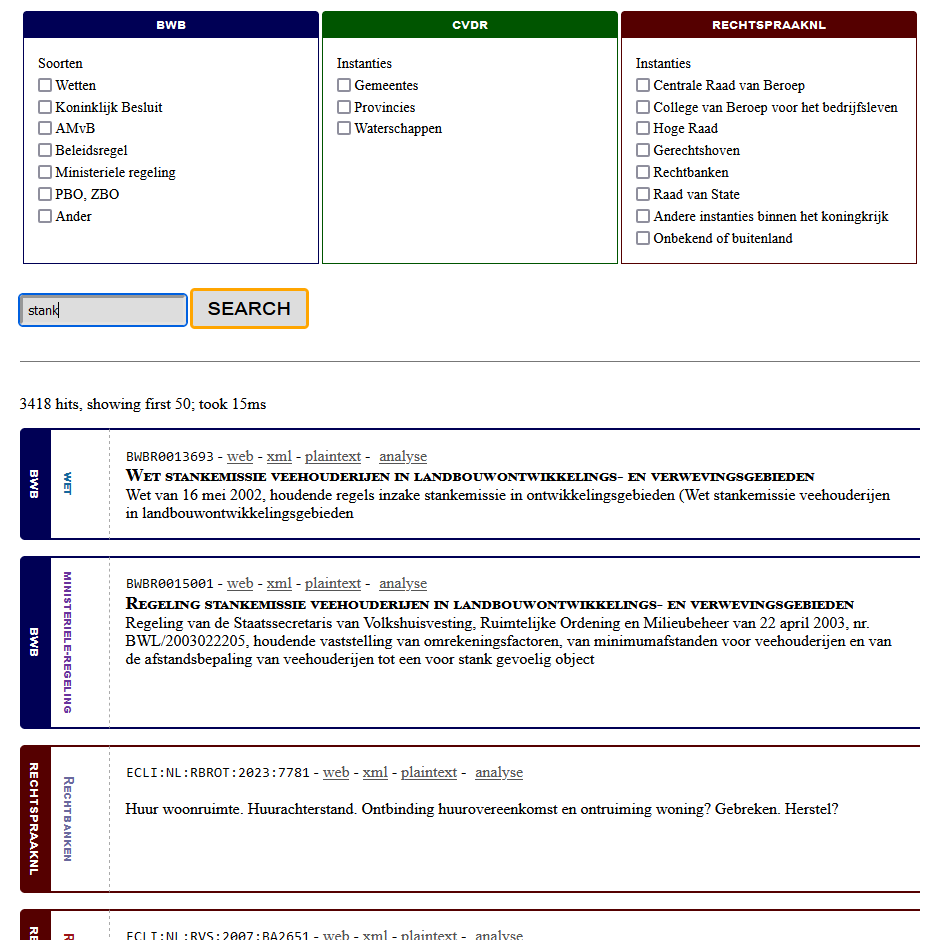